En este notebook vamos a adquirir un conjunto de datos cualquiera y entrenar un clasificador en base a una red pre-entrenada.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook, tnrange
%matplotlib inline

Using TensorFlow backend.


# Adquirir imagenes

Vamos a usar algunas funciones de javascript para obtener imagenes desde el buscador de google.

## Adquirir links

**1. Buscamos un tipo de imagen:**

  <img src="imgs_/js1.png" width="350px" align="left" style="float:left">
  <br style="clear:both">
  
**2. Bajamos hasta tener una buena cantidad de imagenes:**

  <img src="imgs_/js2.png" width="350px" align="left">
  <br style="clear:both">
  
**3. Abrimos la consola del navegador (F12) y pegamos el siguiente codigo (si sale un error, volver a pegar el codigo):**

  ```var script = document.createElement('script');
script.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.2.0/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(script);
var urls = $('.rg_di .rg_meta').map(function() { return JSON.parse($(this).text()).ou; });
var textToSave = urls.toArray().join('\n');
var hiddenElement = document.createElement('a');
hiddenElement.href = 'data:attachment/text,' + encodeURI(textToSave);
hiddenElement.target = '_blank';
hiddenElement.download = 'urls.txt';
hiddenElement.click();```

  <img src="imgs_/js3.png" width="850px" align="left">
  <br style="clear:both">


**4. Guardamos el archivo de texto, con el nombre de la clase:**

  <img src="imgs_/js44.png" width="850px" align="left">
  <br style="clear:both">
  El archivo contiene los links de todas las imagenes que vimos en el buscador.
  
**5. Repetimos lo mismo con las demas clases y colocamos todos los archivos de texto en una carpeta:**

  <img src="imgs_/js5.png" width="250px" align="left">

## Bajar las imagenes

In [2]:
from download import download

# Especificamos carpeta donde pusimos los archivos de texto y ejecutamos el metodo dobbbbwnload
path = 'imgs_ejercicio6'
download(path)

2 clases encontradas: truck, car.
Urls validos: 313
Imagenes a bajar: 313
Imagenes bajadas: 301
Total imagenes: 292

Urls validos: 297
Imagenes a bajar: 297
Imagenes bajadas: 279
Total imagenes: 269



## Cargar las imagenes

In [3]:
img_size = 224
batch_size = 64

In [4]:
# Especificamos la función de preprocesamiento
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size), batch_size=batch_size)

Found 560 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'car': 0, 'truck': 1}

car/Buying-a-pre-owned-car-is-really-a-good-decision.jpg


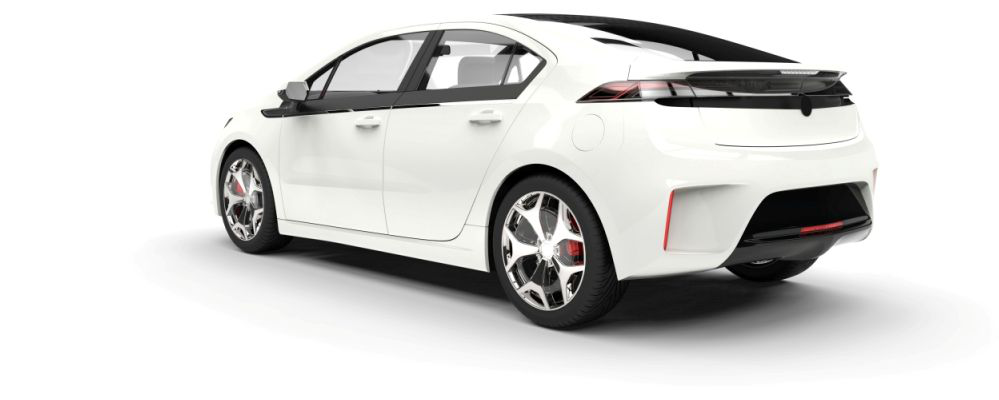

In [7]:
# Veamos alguna de las imágenes
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + '/' + random_img)

# Definimos los modelos

## Red preentrenada

In [8]:
base_model = ResNet50(include_top=False, input_shape=(img_size,img_size,3), pooling='avg')
base_model.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Cabecera de clasificacion

In [20]:
cls_model = Sequential()

cls_model.add(Dense(128, activation='relu', input_shape=(2048,)))
cls_model.add(Dense(train_generator.num_classes, activation='softmax'))

cls_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
cls_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 262,530
Trainable params: 262,530
Non-trainable params: 0
_________________________________________________________________


## Red completa

In [21]:
final_model = Sequential()

final_model.add(base_model)
final_model.add(cls_model)

final_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
sequential_3 (Sequential)    (None, 2)                 262530    
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________


# Precompute

In [11]:
# Vamos a crear nuevamente el generator, pero esta vez con el parámetro "shuffle=False",
# para obtener los resultados en orden
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False)

Found 560 images belonging to 2 classes.


In [12]:
n_batch = math.ceil(train_generator.samples / batch_size)
n_batch

9

In [13]:
# Reseteamos el status del generador para comenzar en orden
train_generator.reset()

# Variables donde vamos a guardar los features extraidos
outputs_x = []
outputs_y = []

# Usamos "tnrange" en lugar de "range" para tener más información del loop
for i in tnrange(n_batch):
    # Obtenemos la información del batch
    batch_x, batch_y = train_generator.next()

    # Guardamos el resultado del base_model
    outputs_x.append(base_model.predict_on_batch(batch_x))
    
    # Guardamos tambien los labels
    outputs_y.append(batch_y)
    
# Usamos la función "vstack" de numpy, para juntar los resultados en forma de un numpy array
outputs_x = np.vstack(outputs_x)
outputs_y = np.vstack(outputs_y)
outputs_x.shape, outputs_y.shape

/home/kopita/anaconda3/envs/ml/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


((560, 2048), (560, 2))

In [14]:
# Guardamos los arrays
np.savez_compressed('data/car_truck_precomputed', x=outputs_x, y=outputs_y)

In [15]:
# Cargar arrays
data = np.load('data/car_truck_precomputed.npz')
outputs_x = data['x']
outputs_y = data['y']

outputs_x.shape, outputs_y.shape

((560, 2048), (560, 2))

# Entrenar a partir de los features extraidos

In [22]:
log = cls_model.fit(outputs_x, outputs_y, epochs=5, batch_size=256)

Epoch 1/5
560/560 [==============================] - 3s 5ms/step - loss: 2.0978 - acc: 0.4911
Epoch 2/5
560/560 [==============================] - 0s 127us/step - loss: 0.4962 - acc: 0.7857
Epoch 3/5
560/560 [==============================] - 0s 126us/step - loss: 0.5372 - acc: 0.7804
Epoch 4/5
560/560 [==============================] - 0s 134us/step - loss: 0.1590 - acc: 0.9393
Epoch 5/5
560/560 [==============================] - 0s 170us/step - loss: 0.2307 - acc: 0.9089


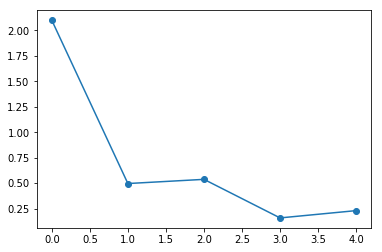

In [23]:
plt.plot(log.history['loss'], '-o');

# Probando el modelo

In [73]:
lbl_dict = {k:i for i,k in train_generator.class_indices.items()}

def get_class(path):
    # Cargar la imagen del path
    img = Image.open(path).convert('RGB')
    
    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')
    
    # Cambiar el tamaño de la imagen
    img_resized = img.resize((224, 224))
    
    # Cambiar a formato numpy y preprocesar
    x = np.asarray(img_resized, np.float32)[None]
    x = preprocess_input(x)
    
    # Obtener predicciones
    y = final_model.predict(x)
    
    # Decodear predicciones
    pred = lbl_dict[np.argmax(y)]
    
    plt.title(f'Model prediction = {pred}')
    plt.show()


imgs_ejercicio6/car/FCAR_800x400.png


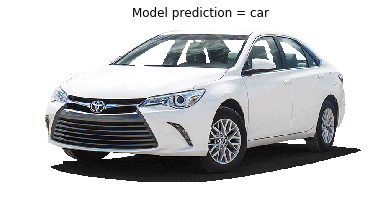

imgs_ejercicio6/truck/what-ever-happened-to-the-affordable-pickup-truck-feature-car-and-driver-photo-657520-s-original.jpg


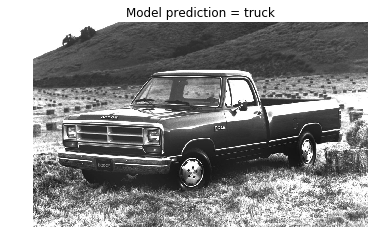

imgs_ejercicio6/car/hqdefault.jpg


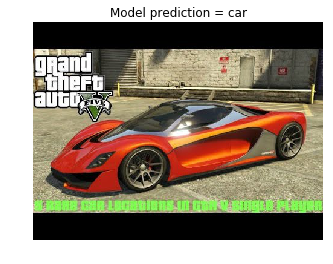

In [74]:
# Nro de pruebas
n = 3

for _ in range(n):
    # Escoger una imagene al azar
    random_path = path + '/' + np.random.choice(train_generator.filenames)
    print(random_path)

    # Obtener la clasificación de la imagen
    get_class(random_path)